# BERT Fine-Tuning

Use of BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification.


# 1. Setup

In [ ]:
!nvidia-smi

Mon Apr 10 14:00:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import torch

## Installing the Hugging Face Library


In [ ]:
!pip install transformers
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import wget
import logging
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from keras.utils import pad_sequences

import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [ ]:
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode).
        When seed is a false-y value or not supplied, disables deterministic mode. """
    if seed:
        logging.info(f"Running in deterministic mode with seed {seed}")
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info(f"Running in non-deterministic mode")
      
set_seed(2023)

In [ ]:
# =============================================================================
# ## check GPU
# =============================================================================
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 2. Loading Dataset


we going to use sentiment data from US airline for sentiment analysis

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment


## Download & Extract

We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [ ]:
# import dataset
df = pd.read_csv(r'https://raw.githubusercontent.com/satyajeetkrjha/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv')[['text','airline_sentiment']]
labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['airline_sentiment'])

# df = df.head(1000)
print('Downloading dataset...')
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 14,640



,text,airline_sentiment,label
3489,@united thanks ^mr i got rebooked already but ...,negative,0
8652,@JetBlue @Cinnabon the two of you should team ...,negative,0
4142,@united thanks! We would like an apology and a...,negative,0
4725,@SouthwestAir : thanks.are flights operating n...,neutral,1
7766,@JetBlue You guys need pillows on these rocker...,neutral,1
4915,@SouthwestAir I requested my boarding pass to ...,negative,0
3768,"@united Thanks, but not so much the missing ba...",negative,0
3047,@united @abigailedge Another glitch??,negative,0
3808,@united just because you are a monopoly in @fl...,negative,0
9078,@USAirways HELLO!! Is anyone behind your twitt...,negative,0


The two properties we actually care about are the the `text` and its `label`, which is referred to as the (0=negative, 1=neutral, 2=positive).

Here are five sentences which are labeled as not grammatically acceptible. Note how much more difficult this task is than something like sentiment analysis!

In [ ]:
df.loc[df.label == 0].sample(5)[['text', 'label']]

,text,label
1629,@united EVERYTIME I fly UR airline I hate you ...,0
12029,@AmericanAir 800 number will not even let you...,0
13838,@AmericanAir Thanks for your canned response t...,0
9177,@USAirways screwed me up big. 1st flight 1hr L...,0
10840,@USAirways Saddens me that my first tweet - ev...,0




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.label.values

In [ ]:
sentences[0], labels[0]

('@VirginAmerica What @dhepburn said.', 1)

# 3. Data preparation and Tokenization
In this section, we'll transform our dataset into the format that BERT can be trained on.

## BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# bert-base-uncased
# microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  @VirginAmerica What @dhepburn said.
Tokenized:  ['@', 'virgin', '##ame', '##rica', 'what', '@', 'dh', '##ep', '##burn', 'said', '.']
Token IDs:  [1030, 6261, 14074, 14735, 2054, 1030, 28144, 13699, 8022, 2056, 1012]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a specific length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Special Tokens



**`[SEP]`**

To determine the end of the sentence, will be useful for QA task, we need to append the special `[SEP]` token. 

**`[CLS]`**

For classification tasks, 
the special `[CLS]` token must be added to the beginning of every sentence.

BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.


### Sentence Length & Attention Mask



BERT has two constraints:
1. All sentences must be padded or truncated to a fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  67


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 67,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  @VirginAmerica What @dhepburn said.
Token IDs: tensor([  101,  1030,  6261, 14074, 14735,  2054,  1030, 28144, 13699,  8022,
         2056,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


## 3.4. Training & Validation Split


Divide up our training set to use 80% for training and 20% for validation.

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} total samples'.format(len(dataset)))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples'.format(test_size))

14,640 total samples
8,784 training samples
2,928 validation samples
2,928 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 64

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

A variety of NLP tasks already pre-trained can be download from huggingface. 
Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification**
* BertForTokenClassification
* BertForQuestionAnswering



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 16 (set when creating our DataLoaders)
* Learning rate: 5e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU
- Clear out the gradients in the previous pass. 
- Forward pass
- Backward pass (backpropagation)
- Update parameters with optimizer.step()
- Monitor progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU
- Forward pass
- Compute loss on our validation data
- Monotor progress


Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

We're ready to kick off the training!

In [ ]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        out           = model(b_input_ids,
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += out[0].item()

        out[0].backward()

        # Clip the norm to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update weight
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            out            = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += out[0].item()

        # Move logits and labels to CPU
        logits = out[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    138.    Elapsed: 0:00:25.
  Batch    80  of    138.    Elapsed: 0:00:51.
  Batch   120  of    138.    Elapsed: 0:01:17.

  Average training loss: 0.53
  Training epcoh took: 0:01:28

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.43
  Validation took: 0:00:11

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    138.    Elapsed: 0:00:27.
  Batch    80  of    138.    Elapsed: 0:00:53.
  Batch   120  of    138.    Elapsed: 0:01:19.

  Average training loss: 0.30
  Training epcoh took: 0:01:31

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.42
  Validation took: 0:00:11

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    138.    Elapsed: 0:00:27.
  Batch    80  of    138.    Elapsed: 0:00:53.
  Batch   120  of    138.    Elapsed: 0:01:20.

  Average training loss: 0.17
  Training epcoh took: 0:01:31

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.49
  Validation too

Let's view the summary of the training process.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.525387,0.429628,0.833560,0:01:28,0:00:11
2,0.301134,0.416037,0.845901,0:01:31,0:00:11
3,0.171781,0.487862,0.842165,0:01:31,0:00:11
4,0.097750,0.555839,0.844882,0:01:32,0:00:11


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

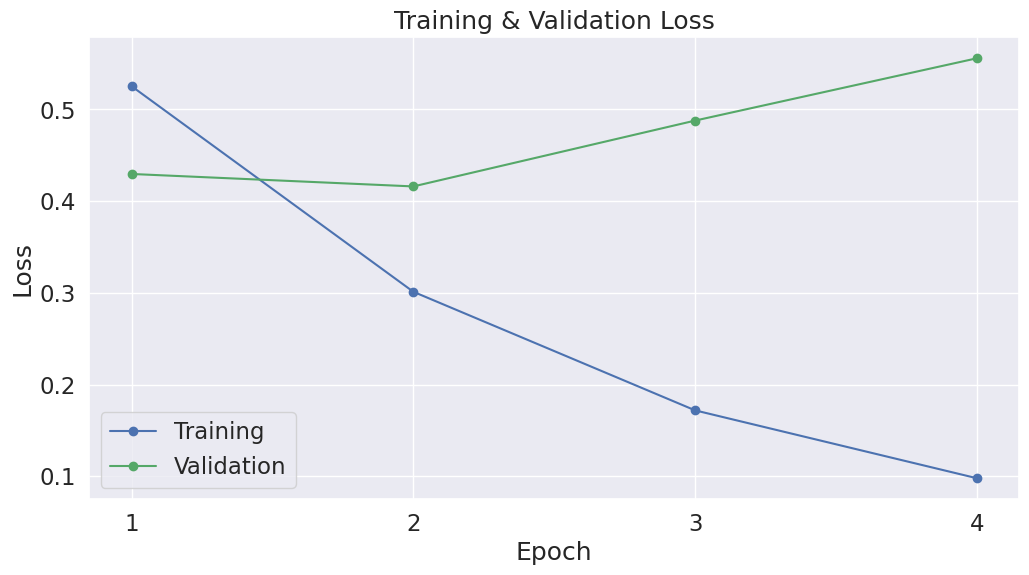

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 14,640 test sentences...
    DONE.


In [ ]:
flat_true_labels = np.concatenate(true_labels, axis=0)
flat_predictions = np.concatenate(predictions, axis=0)

In [ ]:
flat_predictions.shape

(2928, 3)

In [ ]:
flat_true_labels.shape

(2928,)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

In [ ]:
print('f1 score =',f1_score_func(flat_predictions, flat_true_labels))
print('accuracy score =',flat_accuracy(flat_predictions, flat_true_labels))

f1 score = 0.7904984122567492
accuracy score = 0.8367486338797814


# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K ./model_save/

total 427988K
-rw-r--r-- 1 root root      1K Apr 10 14:28 config.json
-rw-r--r-- 1 root root 427746K Apr 10 14:28 pytorch_model.bin
-rw-r--r-- 1 root root      1K Apr 10 14:28 special_tokens_map.json
-rw-r--r-- 1 root root      1K Apr 10 14:28 tokenizer_config.json
-rw-r--r-- 1 root root    227K Apr 10 14:28 vocab.txt


The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 418M Apr 10 14:28 ./model_save/pytorch_model.bin


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/MyDrive/BERT/"

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model.from_pretrained(output_dir)
tokenizer = tokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,